In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import requests
from datetime import datetime
import time # Para pauses na API
import openrouteservice # Biblioteca para ORS API
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb # Import XGBoost
import seaborn as sns
import matplotlib.pyplot as plt

# --- Carregamento e Renomeação Inicial (como no seu código) ---
try:
    # Tente carregar com encoding='utf-8' primeiro
    address_df = pd.read_csv('./data/rideaddress_v1.csv', sep=';', encoding='utf-8', low_memory=False)
except UnicodeDecodeError:
    # Se falhar, tente 'latin-1' ou outro relevante para seus dados
    print("Falha ao carregar com UTF-8, tentando Latin-1...")
    address_df = pd.read_csv('./data/rideaddress_v1.csv', sep=';', encoding='latin-1', low_memory=False)

ride_df = pd.read_csv('./data/ride_v2.csv', sep=';', low_memory=False)
# estimative_df = pd.read_csv('./data/rideestimative_v3.csv', sep=';', low_memory=False) # Descomente se for usar
# product_df = pd.read_csv('./data/product.csv', sep=';', low_memory=False) # Descomente se for usar

# Seleção e Renomeação
address_df = address_df[["Address", "Lat", "Lng", "RideAddressTypeID", "RideID"]]
ride_df = ride_df[["RideID", "Create", "price"]]
# estimative_df = estimative_df[["RideID", "ProductID", "Price"]]

address_df.rename(columns={
    "Address": "address", "Lat": "lat", "Lng": "lng",
    "RideAddressTypeID": "address_type", "RideID": "ride_id"
}, inplace=True)

ride_df.rename(columns={
    "RideID": "ride_id", "Create": "create_datetime_str", "price": "price"
}, inplace=True)

# estimative_df.rename(columns={
#     "RideID": "ride_id", "ProductID": "product_id", "Price": "estimative_price"
# }, inplace=True)

# --- Limpeza de Coordenadas ---
def clean_coord(coord):
    if pd.isna(coord):
        return np.nan
    if isinstance(coord, (int, float)):
        return float(coord)
    if isinstance(coord, str):
        try:
            # Tenta substituir vírgula por ponto e converter para float
            val = float(coord.replace(',', '.'))
            # Verifica limites geográficos aproximados para o Brasil
            # (Ajuste se necessário para sua área específica)
            # if -34 <= val <= 5 or -74 <= val <= -34: # Latitude ou Longitude
            #     return val
            # else:
            #     # print(f"Valor fora do range: {val}") # Opcional: para debug
            #     return np.nan # Fora do range esperado
            return val # Retorna mesmo se fora do range, pode ser outro lugar
        except (ValueError, AttributeError):
            return np.nan
    return np.nan # Caso não seja nenhum dos tipos esperados

print("Limpando coordenadas...")
address_df['lat_clean'] = address_df['lat'].apply(clean_coord)
address_df['lng_clean'] = address_df['lng'].apply(clean_coord)

# Verifica quantos NaNs foram gerados ou já existiam
print(f"Latitudes inválidas/ausentes: {address_df['lat_clean'].isna().sum()}")
print(f"Longitudes inválidas/ausentes: {address_df['lng_clean'].isna().sum()}")

# --- Pivotar para obter origem/destino por ride_id ---
print("Pivotando endereços...")
address_pivoted = address_df.pivot_table(
    index='ride_id',
    columns='address_type',
    values=['lat_clean', 'lng_clean', 'address'], # Inclui 'address' para fallback
    aggfunc={'lat_clean': 'mean', 'lng_clean': 'mean', 'address': 'first'}
)
# Aplaina os nomes das colunas MultiIndex (ex: ('lat_clean', 1) -> 'lat_clean_1')
address_pivoted.columns = ['_'.join(map(str, col)).strip() for col in address_pivoted.columns.values]
address_pivoted.reset_index(inplace=True)

print("Tabela de endereços pivotada:")
print(address_pivoted.head())

# Contar quantos rides têm coordenadas válidas para origem E destino
valid_coords_count = address_pivoted.dropna(subset=['lat_clean_1', 'lng_clean_1', 'lat_clean_2', 'lng_clean_2']).shape[0]
print(f"Número de corridas com coordenadas válidas para origem e destino: {valid_coords_count}")
print(f"Número total de corridas únicas na tabela pivotada: {address_pivoted.shape[0]}")



Limpando coordenadas...
Latitudes inválidas/ausentes: 0
Longitudes inválidas/ausentes: 0
Pivotando endereços...
Tabela de endereços pivotada:
   ride_id                                          address_1  \
0  1183200  Rua João Pinheiro, 585 - Rua João Pinheiro - B...   
1  1183201                                                rid   
2  1183202  Rua Barão do Rio Branco, 12 - Rua Barão do Rio...   
3  1183203               Tv. Duzentos e Sessenta e Um, 72, 72   
4  1183204        Rua Argentina, 160 - Rua Argentina - Brasil   

                                           address_2  lat_clean_1  \
0  Av. Dr. Nereu Ramos, 450 - Rocio Grande, São F...   -26.329754   
1  Angeloni Ingleses (Florianópolis) - Supermerca...   -27.491979   
2  R. Antônio de Albuquerque, 1080 - Funcionários...   -19.849580   
3                 Semar Supermercados Bertioga, 2141   -23.962423   
4  R. Simeão Aguiar, 430 - Novo Paraíso, Aracaju ...   -10.919802   

   lat_clean_2  lng_clean_1  lng_clean_2  
0   -26.2

In [2]:
# -*- coding: utf-8 -*-
# (Continuação do código anterior)

# --- Carregar e Mergir Dados ORS Pré-calculados ---
print("Carregando dados ORS pré-calculados...")
try:
    ors_precalc_df = pd.read_csv('./data/distancia_tempo_corridas.csv')
    ors_precalc_df.rename(columns={
        'RideID':'ride_id', # Garante consistência no nome da coluna
        'distancia_m': 'distance_ors_precalc',
        'tempo_estim_segundos': 'duration_ors_precalc'
    }, inplace=True)
    # Converte ride_id para int se necessário (pode ser lido como float ou object)
    ors_precalc_df['ride_id'] = ors_precalc_df['ride_id'].astype(int)

    # Merge com a tabela pivotada
    address_pivoted = address_pivoted.merge(
        ors_precalc_df[['ride_id', 'distance_ors_precalc', 'duration_ors_precalc']],
        on='ride_id',
        how='left'
    )
    print(f"{len(ors_precalc_df)} corridas com dados ORS pré-calculados carregadas.")
    print(f"Corridas com dados ORS após merge: {address_pivoted['distance_ors_precalc'].notna().sum()}")

except FileNotFoundError:
    print("Arquivo distancia_tempo_corridas.csv não encontrado. Pulando merge.")
    address_pivoted['distance_ors_precalc'] = np.nan
    address_pivoted['duration_ors_precalc'] = np.nan
except Exception as e:
     print(f"Erro ao carregar ou mesclar dados ORS pré-calculados: {e}")
     address_pivoted['distance_ors_precalc'] = np.nan
     address_pivoted['duration_ors_precalc'] = np.nan

# --- Cálculo de Distância/Duração via API ORS (Opcional, requer API Key) ---
# !!! IMPORTANTE: Substitua 'SUA_API_KEY_AQUI' pela sua chave real !!!
# !!! Este bloco pode demorar MUITO para 2 milhões de corridas. Considere executar em partes ou em ambiente mais robusto.
USE_ORS_API = False # Mude para True para ativar a chamada da API
ORS_API_KEY = 'SUA_API_KEY_AQUI' # <<< COLOQUE SUA CHAVE AQUI

if USE_ORS_API and ORS_API_KEY != 'SUA_API_KEY_AQUI':
    print("Configurando cliente ORS API...")
    client = openrouteservice.Client(key=ORS_API_KEY)

    address_pivoted['distance_ors_api'] = np.nan
    address_pivoted['duration_ors_api'] = np.nan

    # Seleciona linhas que NÃO têm dados pré-calculados E TÊM coordenadas válidas
    rows_to_process = address_pivoted[
        address_pivoted['distance_ors_precalc'].isna() &
        address_pivoted['lat_clean_1'].notna() &
        address_pivoted['lng_clean_1'].notna() &
        address_pivoted['lat_clean_2'].notna() &
        address_pivoted['lng_clean_2'].notna()
    ].index

    print(f"Tentando obter dados via API ORS para {len(rows_to_process)} corridas...")
    count = 0
    errors = 0
    for idx in rows_to_process:
        row = address_pivoted.loc[idx]
        coords = ((row['lng_clean_1'], row['lat_clean_1']), (row['lng_clean_2'], row['lat_clean_2'])) # ORS usa (lon, lat)

        try:
            # Verifica se as coordenadas são idênticas
            if coords[0] == coords[1]:
                 dist = 0.0
                 dur = 0.0
            else:
                routes = client.directions(coordinates=coords, profile='driving-car', format='geojson')
                summary = routes['features'][0]['properties']['summary']
                dist = summary['distance']  # metros
                dur = summary['duration']  # segundos

            address_pivoted.loc[idx, 'distance_ors_api'] = dist
            address_pivoted.loc[idx, 'duration_ors_api'] = dur
            count += 1

            if count % 100 == 0: # Log a cada 100 chamadas
                print(f"Processado {count}/{len(rows_to_process)} via API...")

            # Pause para respeitar limites da API (ajuste conforme necessário)
            # 40 reqs/min -> 1.5s por req. Adicione uma margem.
            time.sleep(1.6)

        except openrouteservice.exceptions.ApiError as e:
            print(f"Erro API ORS na linha {idx} (RideID: {row['ride_id']}): {e}")
            # Possíveis erros: 404 (sem rota), 429 (rate limit), 403 (chave inválida), etc.
            errors += 1
            if e.status_code == 429:
                 print("Rate limit atingido, esperando 60s...")
                 time.sleep(60) # Espera mais tempo se for rate limit
            # time.sleep(1.6) # Espera mesmo em erro para não sobrecarregar
        except Exception as e:
            print(f"Erro inesperado na linha {idx} (RideID: {row['ride_id']}): {e}")
            errors += 1
            # time.sleep(1.6)

    print(f"Processamento API ORS concluído. {count} sucessos, {errors} erros.")
else:
    print("API ORS não será utilizada.")
    address_pivoted['distance_ors_api'] = np.nan
    address_pivoted['duration_ors_api'] = np.nan

# --- Cálculo de Distância Haversine (Fallback) ---
print("Calculando distância Haversine (fallback)...")
def haversine_distance_m(lat1, lon1, lat2, lon2):
    # Verifica se alguma coordenada é NaN
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        return np.nan

    R = 6371e3  # Raio da Terra em metros
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return int(round(distance)) # Retorna como inteiro

address_pivoted['distance_haversine'] = address_pivoted.apply(
    lambda row: haversine_distance_m(row['lat_clean_1'], row['lng_clean_1'], row['lat_clean_2'], row['lng_clean_2']),
    axis=1
)

# --- Criar Colunas Finais de Distância e Duração ---
print("Criando colunas finais de distância e duração...")

# Prioridade: ORS Pré-calculado > ORS API > Haversine
address_pivoted['distance_m'] = address_pivoted['distance_ors_precalc'].fillna(
                                 address_pivoted['distance_ors_api']).fillna(
                                 address_pivoted['distance_haversine'])

# Prioridade: ORS Pré-calculado > ORS API
address_pivoted['duration_s'] = address_pivoted['duration_ors_precalc'].fillna(
                                address_pivoted['duration_ors_api'])

# Criar coluna de fonte para análise (opcional)
def get_source(row):
    if pd.notna(row['distance_ors_precalc']):
        return 'ors_precalc'
    elif pd.notna(row['distance_ors_api']):
        return 'ors_api'
    elif pd.notna(row['distance_haversine']):
        return 'haversine'
    else:
        return 'missing'

address_pivoted['distance_source'] = address_pivoted.apply(get_source, axis=1)
print("Distribuição das fontes de distância:")
print(address_pivoted['distance_source'].value_counts())

# Seleciona colunas finais de localização + ride_id
location_features_df = address_pivoted[['ride_id', 'distance_m', 'duration_s', 'distance_source']].copy() # Copia para evitar SettingWithCopyWarning

print("Dados de localização processados:")
print(location_features_df.head())
print(f"Distância média final: {location_features_df['distance_m'].mean():.2f} m")
print(f"Duração média final: {location_features_df['duration_s'].mean():.2f} s")
print(f"Linhas sem distância final: {location_features_df['distance_m'].isna().sum()}")
print(f"Linhas sem duração final: {location_features_df['duration_s'].isna().sum()}")

# Limpa memória se as colunas intermediárias não forem mais necessárias
# del address_pivoted['distance_ors_precalc'], address_pivoted['duration_ors_precalc']
# del address_pivoted['distance_ors_api'], address_pivoted['duration_ors_api']
# del address_pivoted['distance_haversine']

Carregando dados ORS pré-calculados...
178018 corridas com dados ORS pré-calculados carregadas.
Corridas com dados ORS após merge: 173774
API ORS não será utilizada.
Calculando distância Haversine (fallback)...
Criando colunas finais de distância e duração...
Distribuição das fontes de distância:
distance_source
haversine      326226
ors_precalc    173774
Name: count, dtype: int64
Dados de localização processados:
   ride_id  distance_m  duration_s distance_source
0  1183200     21306.0         NaN       haversine
1  1183201     17865.7      1413.2     ors_precalc
2  1183202     16563.8      1505.7     ors_precalc
3  1183203     33860.2      2324.4     ors_precalc
4  1183204      1801.0         NaN       haversine
Distância média final: 15041.47 m
Duração média final: 1028.38 s
Linhas sem distância final: 0
Linhas sem duração final: 326226


In [3]:
# -*- coding: utf-8 -*-
# (Continuação do código anterior)

# --- Processamento de Data/Hora em ride_df (semelhante ao seu código) ---
print("Processando data/hora...")

def fix_date_str(date_str):
    if pd.isna(date_str): return None
    date_str = str(date_str).strip()
    if '.' in date_str:
        parts = date_str.split('.')
        # Garante que a parte da fração de segundo tenha no máximo 6 dígitos
        if len(parts) > 1 and len(parts[1]) > 6:
             # Tenta reconstruir corretamente, considerando possível ausência de segundos
             base_time = parts[0]
             fraction = parts[1][:6]
             # Verifica se a base já tem HH:MM:SS
             time_parts = base_time.split(':')
             if len(time_parts) == 3: # Formato completo
                 return base_time + '.' + fraction
             elif len(time_parts) == 2: # HH:MM, adiciona :00
                 return base_time + ':00.' + fraction
             # Adicione mais lógica se necessário para formatos inesperados
    return date_str

# Aplica correção ANTES de converter para datetime
ride_df['fixed_datetime_str'] = ride_df['create_datetime_str'].apply(fix_date_str)

# Converte para datetime
# `infer_datetime_format=True` pode acelerar, `cache=True` também
# `errors='coerce'` transforma datas inválidas em NaT (Not a Time)
ride_df['datetime'] = pd.to_datetime(ride_df['fixed_datetime_str'], errors='coerce', infer_datetime_format=True, cache=True)

# Verifica se houve erros na conversão
invalid_dates = ride_df['datetime'].isna().sum()
if invalid_dates > 0:
    print(f"Atenção: {invalid_dates} datas não puderam ser convertidas e serão removidas ou precisarão de tratamento!")
    # Opcional: Investigar as linhas com erro
    # print(ride_df[ride_df['datetime'].isna()]['create_datetime_str'].unique()[:10])
    # Decide a ação: remover linhas com NaT ou tentar outra correção/imputação
    ride_df.dropna(subset=['datetime'], inplace=True)


# Cria as colunas de data, hora, dia da semana
ride_df['date_only'] = ride_df['datetime'].dt.date.astype(str) # YYYY-MM-DD como string
ride_df['time_only'] = ride_df['datetime'].dt.strftime('%H:%M:%S') # HH:MM:SS como string
ride_df['weekday'] = ride_df['datetime'].dt.weekday + 1 # Segunda=1, Domingo=7
ride_df['hour_min'] = ride_df['datetime'].dt.hour + ride_df['datetime'].dt.minute / 60.0 # Hora + fração minuto

# --- Adicionar Feriados (usando BrasilAPI) ---
print("Buscando feriados...")
years = ride_df['datetime'].dt.year.unique()
holiday_dates = set()
for year in years:
    if pd.isna(year): continue # Pula anos NaN se houver
    api_url = f"https://brasilapi.com.br/api/feriados/v1/{int(year)}"
    try:
        response = requests.get(api_url, timeout=10) # Adiciona timeout
        if response.status_code == 200:
            feriados = response.json()
            for feriado in feriados:
                holiday_dates.add(feriado.get('date'))
        else:
             print(f"Erro {response.status_code} ao buscar feriados para o ano {int(year)}")
    except requests.exceptions.RequestException as e:
        print(f"Erro de conexão ao buscar feriados para o ano {int(year)}: {e}")
    except Exception as e:
        print(f"Erro inesperado ao buscar feriados para o ano {int(year)}: {e}")

# Cria a coluna 'is_holiday' (0 ou 1)
ride_df['is_holiday'] = ride_df['date_only'].apply(lambda d: 1 if d in holiday_dates else 0)

# --- Features Cíclicas (Opcional, mas recomendado para modelos lineares/árvores) ---
print("Criando features cíclicas...")
ride_df['hour_sin'] = np.sin(2 * np.pi * ride_df['hour_min'] / 24)
ride_df['hour_cos'] = np.cos(2 * np.pi * ride_df['hour_min'] / 24)
ride_df['weekday_sin'] = np.sin(2 * np.pi * ride_df['weekday'] / 7)
ride_df['weekday_cos'] = np.cos(2 * np.pi * ride_df['weekday'] / 7)

# --- Merge Final ---
print("Realizando merge final dos dados...")
# Seleciona colunas relevantes de ride_df
ride_features_df = ride_df[[
    'ride_id', 'price', 'date_only', 'time_only', 'weekday', 'hour_min', 'is_holiday',
    'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos' # Adiciona cíclicas
]].copy() # Copia para evitar SettingWithCopyWarning

# Merge com as features de localização
df_final = pd.merge(ride_features_df, location_features_df, on='ride_id', how='inner')

# Verifica o resultado do merge
print(f"Tamanho do ride_df original: {len(ride_df)}")
print(f"Tamanho do location_features_df: {len(location_features_df)}")
print(f"Tamanho do df_final após merge: {len(df_final)}")

# Remove duplicatas que podem surgir do merge se location_features_df tiver ride_id duplicado
# (Isso não deve acontecer se a pivotagem foi feita corretamente)
initial_len = len(df_final)
df_final.drop_duplicates(subset=['ride_id'], keep='first', inplace=True) # Mantém a primeira ocorrência
if len(df_final) < initial_len:
    print(f"Removidas {initial_len - len(df_final)} linhas duplicadas após merge.")


# --- Tratamento de Zeros/Outliers (Revisão) ---
print(f"Analisando zeros e valores ausentes...\nLinhas com preço zero: {len(df_final[df_final['price'] == 0])}")
print(f"Linhas com distância NaN: {df_final['distance_m'].isna().sum()}")
print(f"Linhas com duração NaN: {df_final['duration_s'].isna().sum()}")

# Decisão: Remover linhas com preço zero (se forem canceladas/inválidas)
# e linhas onde não foi possível calcular a distância (NaN)
original_count = len(df_final)
df_final = df_final[df_final['price'] > 0]
df_final = df_final.dropna(subset=['distance_m']) # Remove se distância for NaN

# Para duração, podemos imputar com 0 ou média se for usar como feature
# Ou simplesmente não usar 'duration_s' se tiver muitos NaNs e a API não foi usada
# Imputando com 0 por enquanto, mas pode não ser ideal.
# df_final['duration_s'].fillna(0, inplace=True) # Exemplo de imputação

final_count = len(df_final)
print(f"Removidas {original_count - final_count} linhas devido a preço zero ou distância NaN.")
print(f"Número final de linhas para treinamento/teste: {final_count}")


# --- Preparação Final para Modelo ---
# Converte date_only para datetime para extrair dia/mês/ano
df_final['date'] = pd.to_datetime(df_final['date_only'])
df_final['day'] = df_final['date'].dt.day
df_final['month'] = df_final['date'].dt.month
df_final['year'] = df_final['date'].dt.year

# Define as features finais
features = [
    # Features de Tempo
    'hour_min', # Ou usar 'hour_sin', 'hour_cos'
    'hour_sin',
    'hour_cos',
    'weekday',  # Ou usar 'weekday_sin', 'weekday_cos'
    'weekday_sin',
    'weekday_cos',
    'is_holiday',
    'day',
    'month',
    'year',
    # Features de Localização
    'distance_m',
    'duration_s', # Adicionar se confiável e não tiver muitos NaNs
    # Outras features potenciais (ex: clustering, produto - se relevante)
]
target = 'price'

# Remove colunas que não são features ou target, se existirem NaNs em features a serem usadas
# Verifica se 'duration_s' será usada e se tem NaNs
if 'duration_s' in features and df_final['duration_s'].isna().any():
    print("Coluna 'duration_s' contém NaNs. Removendo ou imputando...")
    # Opção 1: Remover a feature
    # features.remove('duration_s')
    # Opção 2: Imputar (ex: com a média)
    mean_duration = df_final['duration_s'].mean()
    df_final['duration_s'].fillna(mean_duration, inplace=True)
    print(f"NaNs em 'duration_s' imputados com a média: {mean_duration:.2f}")

# Garante que não há NaNs nas features selecionadas
df_final.dropna(subset=features, inplace=True)
print(f"Número de linhas após remover NaNs nas features: {len(df_final)}")


print("DataFrame final pronto para modelagem:")
print(df_final[features + [target]].head())
print(df_final[features].info()) # Verifica os tipos de dados das features

Processando data/hora...


/var/folders/rm/xlpq0r253874tdc0617z36980000gn/T/ipykernel_13905/1243267001.py:32: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ride_df['datetime'] = pd.to_datetime(ride_df['fixed_datetime_str'], errors='coerce', infer_datetime_format=True, cache=True)


Buscando feriados...
Criando features cíclicas...
Realizando merge final dos dados...
Tamanho do ride_df original: 500000
Tamanho do location_features_df: 500000
Tamanho do df_final após merge: 499998
Analisando zeros e valores ausentes...
Linhas com preço zero: 26628
Linhas com distância NaN: 0
Linhas com duração NaN: 326224
Removidas 26628 linhas devido a preço zero ou distância NaN.
Número final de linhas para treinamento/teste: 473370
Coluna 'duration_s' contém NaNs. Removendo ou imputando...
NaNs em 'duration_s' imputados com a média: 1020.11
Número de linhas após remover NaNs nas features: 473370
DataFrame final pronto para modelagem:
    hour_min  hour_sin  hour_cos  weekday  weekday_sin  weekday_cos  \
1  14.433333 -0.594823 -0.803857        1     0.781831      0.62349   
2  14.400000 -0.587785 -0.809017        1     0.781831      0.62349   
3  14.383333 -0.584250 -0.811574        1     0.781831      0.62349   
4  14.316667 -0.569997 -0.821647        1     0.781831      0.62349

/var/folders/rm/xlpq0r253874tdc0617z36980000gn/T/ipykernel_13905/1243267001.py:160: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['duration_s'].fillna(mean_duration, inplace=True)


Dividindo dados em treino e teste...
Tamanho do treino: 378696, Tamanho do teste: 94674
Treinando Regressão Linear...

Treinando XGBoost...

--- Resultados Regressão Linear ---
RMSE: 47.0185
R² Score: 0.9430
Acurácia: 0.8279
Precisão: 0.7903
Recall: 0.8926
F1-score: 0.8383

--- Resultados XGBoost ---
RMSE: 146.9782
R² Score: 0.4430
Acurácia: 0.8854
Precisão: 0.8651
Recall: 0.9134
F1-score: 0.8886

Importância das Features (XGBoost):
             importance
distance_m     0.237579
day            0.100327
year           0.095518
hour_cos       0.094664
hour_sin       0.077340
weekday_sin    0.076595
hour_min       0.070659
month          0.067151
weekday        0.066892
weekday_cos    0.051760
duration_s     0.045115
is_holiday     0.016399


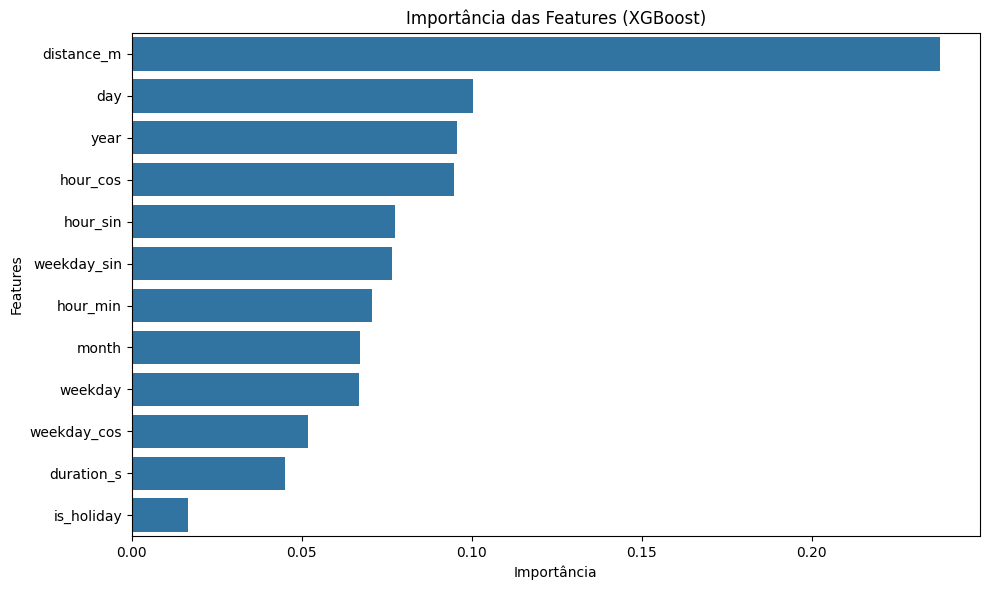


Comparação:
Linear Regression: RMSE=47.0185, R²=0.9430, Acurácia=0.8279, Precisão=0.7903, Recall=0.8926, F1=0.8383
XGBoost:           RMSE=146.9782, R²=0.4430, Acurácia=0.8854, Precisão=0.8651, Recall=0.9134, F1=0.8886

Melhor modelo selecionado: Linear Regression

--- Interface de Previsão ---


In [ ]:
# -*- coding: utf-8 -*-
# (Continuação do código anterior)

# --- Divisão Treino/Teste ---
print("Dividindo dados em treino e teste...")
X = df_final[features]
y = df_final[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamanho do treino: {len(X_train)}, Tamanho do teste: {len(X_test)}")

# --- Treinamento: Regressão Linear ---
print("Treinando Regressão Linear...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Previsões e Avaliação
lr_preds = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = lr_model.score(X_test, y_test) # R² Score

# --- Treinamento: XGBoost Regressor ---
print("\nTreinando XGBoost...")
# Parâmetros básicos, podem ser otimizados com GridSearchCV ou RandomizedSearchCV
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Objetivo para regressão
    n_estimators=100,             # Número de árvores (pode aumentar)
    learning_rate=0.1,            # Taxa de aprendizado (pode ajustar)
    max_depth=5,                  # Profundidade máxima (pode ajustar)
    subsample=0.8,                # Fração de amostras por árvore
    colsample_bytree=0.8,         # Fração de features por árvore
    random_state=42,
    n_jobs=-1                     # Usar todos os cores disponíveis
)

xgb_model.fit(X_train, y_train)

# Previsões e Avaliação
xgb_preds = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = xgb_model.score(X_test, y_test)

# --- Métricas adicionais para regressão e classificação ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def regression_to_class(y_true, y_pred, n_bins=2):
    # Binariza ou categoriza as previsões e verdadeiros para métricas de classificação
    # Exemplo: acima/abaixo da mediana
    median = np.median(y_true)
    y_true_bin = (y_true >= median).astype(int)
    y_pred_bin = (y_pred >= median).astype(int)
    return y_true_bin, y_pred_bin

# Para Linear Regression
y_true_bin_lr, y_pred_bin_lr = regression_to_class(y_test, lr_preds)
lr_accuracy = accuracy_score(y_true_bin_lr, y_pred_bin_lr)
lr_precision = precision_score(y_true_bin_lr, y_pred_bin_lr)
lr_recall = recall_score(y_true_bin_lr, y_pred_bin_lr)
lr_f1 = f1_score(y_true_bin_lr, y_pred_bin_lr)

# Para XGBoost
y_true_bin_xgb, y_pred_bin_xgb = regression_to_class(y_test, xgb_preds)
xgb_accuracy = accuracy_score(y_true_bin_xgb, y_pred_bin_xgb)
xgb_precision = precision_score(y_true_bin_xgb, y_pred_bin_xgb)
xgb_recall = recall_score(y_true_bin_xgb, y_pred_bin_xgb)
xgb_f1 = f1_score(y_true_bin_xgb, y_pred_bin_xgb)

print(f"\n--- Resultados Regressão Linear ---")
print(f"RMSE: {lr_rmse:.4f}")
print(f"R² Score: {lr_r2:.4f}")
print(f"Acurácia: {lr_accuracy:.4f}")
print(f"Precisão: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-score: {lr_f1:.4f}")

print(f"\n--- Resultados XGBoost ---")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"R² Score: {xgb_r2:.4f}")
print(f"Acurácia: {xgb_accuracy:.4f}")
print(f"Precisão: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1-score: {xgb_f1:.4f}")

# --- Análise de Importância de Features (XGBoost) ---
try:
    feature_importances = pd.DataFrame(xgb_model.feature_importances_,
                                       index = X_train.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    print("\nImportância das Features (XGBoost):")
    print(feature_importances)

    # Plotar importância
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances.importance, y=feature_importances.index)
    plt.title('Importância das Features (XGBoost)')
    plt.xlabel('Importância')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Não foi possível gerar importância das features: {e}")

# --- Comparação e Próximos Passos ---
print("\nComparação:")
print(f"Linear Regression: RMSE={lr_rmse:.4f}, R²={lr_r2:.4f}, Acurácia={lr_accuracy:.4f}, Precisão={lr_precision:.4f}, Recall={lr_recall:.4f}, F1={lr_f1:.4f}")
print(f"XGBoost:           RMSE={xgb_rmse:.4f}, R²={xgb_r2:.4f}, Acurácia={xgb_accuracy:.4f}, Precisão={xgb_precision:.4f}, Recall={xgb_recall:.4f}, F1={xgb_f1:.4f}")

# Você pode escolher o melhor modelo com base no RMSE (menor é melhor) e R² (mais próximo de 1 é melhor)
melhor_modelo = xgb_model if xgb_rmse < lr_rmse else lr_model
print(f"\nMelhor modelo selecionado: {'XGBoost' if melhor_modelo == xgb_model else 'Linear Regression'}")


# --- Interface de Previsão (usando o melhor modelo) ---
def predict_price_final(model, feature_names):
    print("\n--- Interface de Previsão ---")
    input_data = {}
    try:
        # Pede entrada para features básicas
        input_data['hour_val'] = float(input("Digite a hora (ex: 15.5 para 15:30): "))
        input_data['weekday_val'] = int(input("Digite weekday (Segunda=1, ... Domingo=7): "))
        input_data['is_holiday'] = int(input("É feriado? Digite 1 para Sim ou 0 para Não: "))
        input_data['distance_m'] = float(input("Digite distance_m (distância em metros): "))
        if 'duration_s' in feature_names:
            input_data['duration_s'] = float(input("Digite duration_s (duração estimada em segundos): "))
        input_data['day'] = int(input("Digite o dia do mês: "))
        input_data['month'] = int(input("Digite o mês (número): "))
        input_data['year'] = int(input("Digite o ano (ex: 2025): "))

        # Calcula features derivadas (cíclicas e hour_min)
        input_data['hour_min'] = input_data['hour_val'] # Assume que a entrada já é hour + min/60
        input_data['hour_sin'] = np.sin(2 * np.pi * input_data['hour_min'] / 24)
        input_data['hour_cos'] = np.cos(2 * np.pi * input_data['hour_min'] / 24)
        input_data['weekday_sin'] = np.sin(2 * np.pi * input_data['weekday_val'] / 7)
        input_data['weekday_cos'] = np.cos(2 * np.pi * input_data['weekday_val'] / 7)
        input_data['weekday'] = input_data['weekday_val'] # Mantém a original também

        # Cria DataFrame na ordem correta das features do modelo
        features_input_list = []
        for feature in feature_names:
            if feature in input_data:
                features_input_list.append(input_data[feature])
            else:
                # Se alguma feature do modelo não foi solicitada (improvável aqui),
                # precisa tratar (ex: erro ou valor padrão)
                print(f"Atenção: Feature '{feature}' não encontrada na entrada.")
                return None # Ou use um valor padrão se fizer sentido

        features_input_df = pd.DataFrame([features_input_list], columns=feature_names)

    except ValueError:
        print("Erro: Entrada inválida. Certifique-se de digitar números.")
        return
    except Exception as e:
        print(f"Erro na entrada de dados: {e}")
        return

    # Previsão usando o modelo selecionado
    predicted_price = model.predict(features_input_df)[0]
    print(f"\nPreço previsto: R$ {predicted_price:.2f}")

# Chama a interface com o melhor modelo e a lista de features usadas no treino
predict_price_final(melhor_modelo, features)

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [ ]:
# Garante features e target
features = ['hour_min', 'hour_sin', 'hour_cos', 'weekday', 'weekday_sin', 'weekday_cos',
            'is_holiday', 'day', 'month', 'year', 'distance_m', 'duration_s']
target = 'price'


In [ ]:
# Divide os dados
X = df_final[features]
y = df_final[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treina o modelo
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_preds = linear_model.predict(X_test)


In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=linear_preds, alpha=0.5)
plt.xlabel("Preço Real")
plt.ylabel("Preço Previsto")
plt.title("Regressão Linear – Real vs Previsto")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
errors = y_test - linear_preds
plt.figure(figsize=(8, 5))
sns.histplot(errors, kde=True, bins=30)
plt.xlabel("Erro (Real – Previsto)")
plt.title("Distribuição dos Erros – Regressão Linear")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
feature_importance = pd.DataFrame({
    'feature': features,
    'coeficiente': linear_model.coef_
}).sort_values(by='coeficiente', key=abs, ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importance, x='coeficiente', y='feature', palette='viridis')
plt.title("Importância das Variáveis – Regressão Linear")
plt.grid(True)
plt.tight_layout()
plt.show()
